In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import catboost as cb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import re
import urllib.request
import requests
import lxml.html as lh
import pandas as pd
#from bs4 import BeautifulSoup, Comment
import pymongo
from keras.utils import np_utils

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/phishing-july/phish_8_july_phishing.csv
/kaggle/input/phishing-july/phish_8_july_alexa.csv
/kaggle/input/phishing-july/phishdb_8_july.csv


In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        if feature_name not in ['Result']:
            max_value = df[feature_name].astype(float).max()
            min_value = df[feature_name].astype(float).min()
            if max_value > min_value:
                result[feature_name] = (df[feature_name].astype(float) - min_value) / (max_value - min_value)
    return result

df_alexa = pd.read_csv("../input/phishing-july/phish_8_july_alexa.csv")
df_phish = pd.read_csv("../input/phishing-july/phishdb_8_july.csv")

In [3]:
df_alexa['phishing'] = 0
df_phish['phishing'] = 1

In [4]:
print(len(df_alexa.columns))
print(len(df_phish.columns))

198
160


In [5]:
frames = [df_alexa, df_phish]
df = pd.concat(frames)

In [6]:
df.head()

,CDN,Server,Web Master,Web Server,_id,ads,ads_ad-analytics,ads_ad-blocking,ads_ad-exchange,ads_ad-network,...,widgets_wordpress-plugins,phishing,ads_bitcoin,hosting_french-hosting,hosting_italian-hosting,hosting_swiss-hosting,hosting_wordpress-hosting,shop_woocommerce-extension,shop_wordpress-plugins,widgets_joomla-module
0,NaN,NaN,NaN,NaN,https://youtube.com,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2.0,3.0,https://jd.com,2.0,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,4.0,4.0,https://amazon.com,17.0,0.0,NaN,0.0,0.0,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,2.0,3.0,https://zoom.us,11.0,0.0,NaN,1.0,2.0,...,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2.0,9.0,https://sina.com.cn,27.0,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = df.drop('_id', axis=1)
df = df.drop('description', axis=1)
df = df.drop('title', axis=1)
df = df.drop('http', axis=1)
df = df.drop('https', axis=1)
df = df.drop('url', axis=1)
df = df.drop('CDN', axis=1)
df = df.drop('Server', axis=1)
df = df.drop('alexa', axis=1)
df = df.drop('status', axis=1)

In [8]:
df.head()

,Web Master,Web Server,ads,ads_ad-analytics,ads_ad-blocking,ads_ad-exchange,ads_ad-network,ads_ad-server,ads_ads-txt,ads_adult,...,widgets_wordpress-plugins,phishing,ads_bitcoin,hosting_french-hosting,hosting_italian-hosting,hosting_swiss-hosting,hosting_wordpress-hosting,shop_woocommerce-extension,shop_wordpress-plugins,widgets_joomla-module
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,4.0,17.0,0.0,NaN,0.0,0.0,1.0,1.0,NaN,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,3.0,11.0,0.0,NaN,1.0,2.0,1.0,NaN,NaN,...,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,9.0,27.0,NaN,NaN,NaN,NaN,NaN,19.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df = df.fillna(0)

In [10]:
df.head()

,Web Master,Web Server,ads,ads_ad-analytics,ads_ad-blocking,ads_ad-exchange,ads_ad-network,ads_ad-server,ads_ads-txt,ads_adult,...,widgets_wordpress-plugins,phishing,ads_bitcoin,hosting_french-hosting,hosting_italian-hosting,hosting_swiss-hosting,hosting_wordpress-hosting,shop_woocommerce-extension,shop_wordpress-plugins,widgets_joomla-module
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4.0,17.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3.0,11.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,...,3.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,9.0,27.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df['copyright_presence']

0         True
1        False
2        False
3        False
4        False
         ...  
73633    False
73634        0
73635    False
73636    False
73637    False
Name: copyright_presence, Length: 142518, dtype: object

In [12]:
df['privacy_policy'] = df['privacy_policy'].replace(to_replace ="NA", value =False)


df = df.replace(to_replace =1.0, value =1)
df = df.replace(to_replace =2.0, value =2)
df = df.replace(to_replace =3.0, value =3)
df = df.replace(to_replace =4.0, value =4)
df = df.replace(to_replace =5.0, value =5)
df = df.replace(to_replace =6.0, value =6)
df = df.replace(to_replace =7.0, value =7)
df = df.replace(to_replace =8.0, value =8)
df = df.replace(to_replace =9.0, value =9)
df = df.replace(to_replace =10.0, value =10)
df = df.replace(to_replace =11.0, value =11)
df = df.replace(to_replace =12.0, value =12)
df = df.replace(to_replace =13.0, value =13)
df = df.replace(to_replace =14.0, value =14)
df = df.replace(to_replace =15.0, value =15)
df = df.replace(to_replace =16.0, value =16)
df = df.replace(to_replace =17.0, value =17)
df = df.replace(to_replace =18.0, value =18)
df = df.replace(to_replace =19.0, value =19)
df = df.replace(to_replace =20.0, value =20)
df = df.replace(to_replace =21.0, value =21)
df = df.replace(to_replace =22.0, value =22)
df = df.replace(to_replace =23.0, value =23)
df = df.replace(to_replace =24.0, value =24)
df = df.replace(to_replace =25.0, value =25)
df = df.replace(to_replace =26.0, value =26)
df = df.replace(to_replace =27.0, value =27)
df = df.replace(to_replace =28.0, value =28)
df = df.replace(to_replace =29.0, value =29)
df = df.replace(to_replace =30.0, value =30)
df = df.replace(to_replace =31.0, value =31)
df = df.replace(to_replace =32.0, value =32)
df = df.replace(to_replace =33.0, value =33)
df = df.replace(to_replace =34.0, value =34)
df = df.replace(to_replace =35.0, value =35)
df = df.replace(to_replace =36.0, value =36)
df = df.replace(to_replace =37.0, value =37)
df = df.replace(to_replace =38.0, value =38)


df = df.replace(to_replace ="social-management-1.0", value ="social-management-1")
df = df.replace(to_replace ="social-management-2.0", value ="social-management-2")
df = df.replace(to_replace ="social-management-1.0", value ="social-management-1")


df = df.replace(to_replace ="multi-channel-1.0", value ="multi-channel-1")
df = df.replace(to_replace ="multi-channel-2.0", value ="multi-channel-2")
df = df.replace(to_replace ="multi-channel-3.0", value ="multi-channel-3")


df = df.replace(to_replace ="retargeting-/-remarketing-1.0", value ="retargeting-/-remarketing-1")
df = df.replace(to_replace ="retargeting-/-remarketing-2.0", value ="retargeting-/-remarketing-2")
df = df.replace(to_replace ="retargeting-/-remarketing-3.0", value ="retargeting-/-remarketing-3")
df = df.replace(to_replace ="retargeting-/-remarketing-4.0", value ="retargeting-/-remarketing-4")
df = df.replace(to_replace ="retargeting-/-remarketing-5.0", value ="retargeting-/-remarketing-5")

df = df.replace(to_replace ="social-management-1.0", value ="social-management-1")
df = df.replace(to_replace ="social-management-2.0", value ="social-management-2")

# hosting_australian-hosting- دانشگاه علوم پزشکی ایران
# hosting_australian-hosting-Thai JobJob News
#                 hosting_australian-hosting-سرمه دان(داروخانه اینترنتی دکتر طهماسبی)
# hosting_australian-hosting-人生を変える方法 Soul Design 心羽
#          hosting_canadian-hosting-https://core-zero.com
#                 hosting_canadian-hosting-https://iums.ac.ir
#                 hosting_canadian-hosting-https://sormedan.com
#                 hosting_canadian-hosting-https://thaijobjob.com

df['ads_retargeting-/-remarketing'] = df['ads_retargeting-/-remarketing'].replace(to_replace ="true", value =1)   
df['cms_social-management'] = df['cms_social-management'].replace(to_replace ="false", value =0)   
df['ads_multi-channel'] = df['ads_multi-channel'].replace(to_replace ="false", value =0)  
df['hosting'] = df['hosting'].replace(to_replace ="true", value =1)
                
df['hosting_australian-hosting'] = df['hosting_australian-hosting'].replace(to_replace =" دانشگاه علوم پزشکی ایران", value =0) 
df['hosting_australian-hosting'] = df['hosting_australian-hosting'].replace(to_replace ="Thai JobJob News", value =0) 
df['hosting_australian-hosting'] = df['hosting_australian-hosting'].replace(to_replace ="سرمه دان(داروخانه اینترنتی دکتر طهماسبی)", value =0) 
df['hosting_australian-hosting'] = df['hosting_australian-hosting'].replace(to_replace ="人生を変える方法 Soul Design 心羽", value =0) 
                
                
df['hosting_canadian-hosting'] = df['hosting_canadian-hosting'].replace(to_replace ="https://core-zero.com", value =0) 
df['hosting_canadian-hosting'] = df['hosting_canadian-hosting'].replace(to_replace ="https://iums.ac.ir", value =0)
df['hosting_canadian-hosting'] = df['hosting_canadian-hosting'].replace(to_replace ="https://sormedan.com", value =0) 
df['hosting_canadian-hosting'] = df['hosting_canadian-hosting'].replace(to_replace ="https://thaijobjob.com", value =0) 

df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-1", value ="australian-hosting-1.0")
df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-2", value ="australian-hosting-2.0")
df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-3", value ="australian-hosting-3.0")
df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-4", value ="australian-hosting-4.0")
df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-5", value ="australian-hosting-5.0")

df['hosting'] = df['hosting'].replace(to_replace ="canadian-hosting-1", value ="canadian-hosting-1.0")
df['hosting'] = df['hosting'].replace(to_replace ="canadian-hosting-2", value ="canadian-hosting-2.0")
df['hosting'] = df['hosting'].replace(to_replace ="canadian-hosting-3", value ="canadian-hosting-3.0")

In [13]:
#copyright_presence
#current_year_match_copyright
#http
#https
#privacy_policy

df['copyright_presence'] = df["copyright_presence"].astype(int)

In [14]:
df['current_year_match_copyright'] = df["current_year_match_copyright"].astype(int)

In [15]:
df['privacy_policy'] = df["privacy_policy"].astype(int)
df['hosting_australian-hosting'] = df["hosting_australian-hosting"].astype(int)
df['hosting_canadian-hosting'] = df["hosting_canadian-hosting"].astype(int)
df['ads_retargeting-/-remarketing'] = df["ads_retargeting-/-remarketing"].astype(int)
df['cms_social-management'] = df["cms_social-management"].astype(int)
df['ads_multi-channel'] = df["ads_multi-channel"].astype(int)
df['hosting'] = df["hosting"].astype(int)
# df['ads'] = df["ads"].astype(int)
# df['ads_retargeting-/-remarketing'] = df["ads_retargeting-/-remarketing"].astype(int)
# df['cms_social-management'] = df["cms_social-management"].astype(int)
# df['hosting'] = df["hosting"].astype(int)
# df['hosting_australian'] = df["hosting_australian"].astype(int)
# df['hosting_canadian'] = df["hosting_canadian"].astype(int)

In [16]:
# encode_text_dummy(df, 'ads_multi-channel')
# encode_text_dummy(df, 'ads_retargeting-/-remarketing')
# encode_text_dummy(df, 'cms_social-management')
# encode_text_dummy(df, 'hosting')
# encode_text_dummy(df, 'hosting_australian-hosting')
# encode_text_dummy(df, 'hosting_canadian-hosting')

In [17]:
# df['status'] = df["status"].astype(int)

In [18]:
df.columns

Index(['Web Master', 'Web Server', 'ads', 'ads_ad-analytics',
       'ads_ad-blocking', 'ads_ad-exchange', 'ads_ad-network', 'ads_ad-server',
       'ads_ads-txt', 'ads_adult',
       ...
       'widgets_wordpress-plugins', 'phishing', 'ads_bitcoin',
       'hosting_french-hosting', 'hosting_italian-hosting',
       'hosting_swiss-hosting', 'hosting_wordpress-hosting',
       'shop_woocommerce-extension', 'shop_wordpress-plugins',
       'widgets_joomla-module'],
      dtype='object', length=196)

In [19]:
print(df.dtypes.unique())

[dtype('float64') dtype('int64')]


In [20]:
x = {}
x['columns'] = df.columns
x['dtype'] = []
for t in df.columns:
    x['dtype'].append(df[t].dtype)

In [21]:
df_col = pd.DataFrame(x)
df_col.to_csv('out.csv')

In [22]:
df.apply(pd.to_numeric)

,Web Master,Web Server,ads,ads_ad-analytics,ads_ad-blocking,ads_ad-exchange,ads_ad-network,ads_ad-server,ads_ads-txt,ads_adult,...,widgets_wordpress-plugins,phishing,ads_bitcoin,hosting_french-hosting,hosting_italian-hosting,hosting_swiss-hosting,hosting_wordpress-hosting,shop_woocommerce-extension,shop_wordpress-plugins,widgets_joomla-module
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4.0,17.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3.0,11.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,...,3.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,9.0,27.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73633,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [24]:
X = df.loc[:,df.columns != "phishing"].values
y = df["phishing"].values

In [25]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [26]:
X_train, X_test_main, y_train, y_test_main = train_test_split(X, y, train_size=0.8, random_state = 0)

In [27]:
X_val, X_test, y_val, y_test = train_test_split(X_test_main, y_test_main, train_size=0.5, random_state = 0)

In [28]:
dummies_test = pd.get_dummies(y_train) # Classification
outcomes_test = dummies_test.columns
num_classes = len(outcomes_test)
train_y = dummies_test.values

dummies_test = pd.get_dummies(y_val) # Classification
outcomes_test = dummies_test.columns
num_classes = len(outcomes_test)
val_y = dummies_test.values

dummies_test = pd.get_dummies(y_test) # Classification
outcomes_test = dummies_test.columns
num_classes = len(outcomes_test)
test_y = dummies_test.values

In [29]:
model = Sequential()
model.add(Dense(16, input_dim=195, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
history=model.fit(X_train, train_y,validation_data=(X_val,val_y), epochs=20)

Epoch 1/20
3563/3563 [==============================] - 6s 2ms/step - loss: 0.3127 - accuracy: 0.8907 - val_loss: 0.2551 - val_accuracy: 0.9135
Epoch 2/20
3563/3563 [==============================] - 5s 1ms/step - loss: 0.2478 - accuracy: 0.9157 - val_loss: 0.2420 - val_accuracy: 0.9166
Epoch 3/20
3563/3563 [==============================] - 5s 2ms/step - loss: 0.2431 - accuracy: 0.9176 - val_loss: 0.2393 - val_accuracy: 0.9180
Epoch 4/20
3563/3563 [==============================] - 5s 2ms/step - loss: 0.2347 - accuracy: 0.9205 - val_loss: 0.2314 - val_accuracy: 0.9209
Epoch 5/20
3563/3563 [==============================] - 5s 1ms/step - loss: 0.2326 - accuracy: 0.9216 - val_loss: 0.2296 - val_accuracy: 0.9212
Epoch 6/20
3563/3563 [==============================] - 5s 2ms/step - loss: 0.2309 - accuracy: 0.9220 - val_loss: 0.2399 - val_accuracy: 0.9179
Epoch 7/20
3563/3563 [==============================] - 5s 1ms/step - loss: 0.2308 - accuracy: 0.9215 - val_loss: 0.2310 - val_accuracy:

In [31]:
y_test.shape

(14252,)

In [32]:
pred = model.predict(X_test)


In [33]:
pred

array([[9.9999738e-01, 2.6233668e-06],
       [9.9323761e-01, 6.7623160e-03],
       [9.9928576e-01, 7.1421138e-04],
       ...,
       [1.3653237e-01, 8.6346763e-01],
       [9.9605894e-01, 3.9410433e-03],
       [9.9933833e-01, 6.6170661e-04]], dtype=float32)

In [34]:
pred.shape

(14252, 2)

In [35]:
test_y.shape

(14252, 2)

In [36]:
pred = np.argmax(pred,axis=1)
test_y = np.argmax(test_y,axis=1)
score = metrics.accuracy_score(test_y, pred)
print("Test score: {}".format(score))

Test score: 0.9264664608476003


In [37]:
pred.shape

(14252,)

In [38]:
y_test == pred

array([ True,  True,  True, ...,  True,  True,  True])

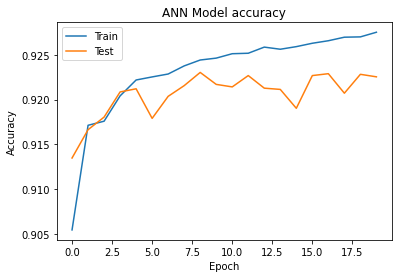

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ANN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

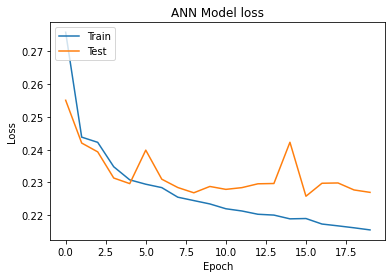

In [40]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('ANN Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

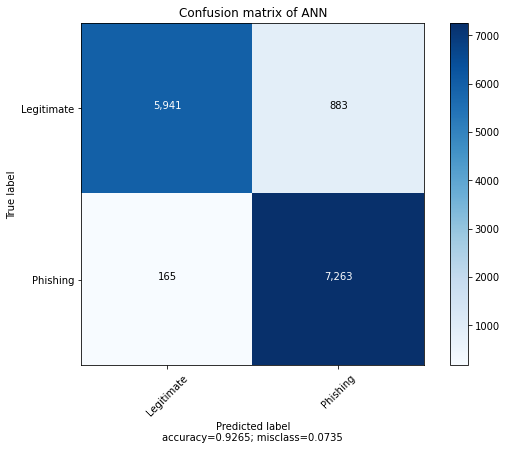

In [41]:
cm = confusion_matrix(test_y, pred)
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['Legitimate', 'Phishing'],
                      title        = "Confusion matrix of ANN")

In [42]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))

In [43]:
X_train.shape

(114014, 195, 1)

In [44]:
X_val.shape

(14252, 195, 1)

In [45]:
batch_size = 64
model2 = Sequential()
model2.add(LSTM(16, input_shape=(195,1), return_sequences=True))
model2.add(LSTM(16, return_sequences=True))
model2.add(LSTM(16, return_sequences=True))
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [46]:
# history2 = model2.fit(X_train, train_y, validation_data=(X_val, val_y), epochs=20)

In [47]:
# pred2 = model2.predict(X_test)
# pred2 = np.argmax(pred2,axis=1)

In [48]:
# score2 = metrics.accuracy_score(test_y, pred2)
# print("Validation score: {}".format(score2))

In [49]:
# cm2 = confusion_matrix(test_y, pred2)
# plot_confusion_matrix(cm           = cm2, 
#                       normalize    = False,
#                       target_names = ['Legitimate', 'Phishing'],
#                       title        = "Confusion matrix of LSTM Network")

In [50]:
# plt.plot(history2.history['accuracy'])
# plt.plot(history2.history['val_accuracy'])
# plt.title('LSTM Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [51]:
# plt.plot(history2.history['loss']) 
# plt.plot(history2.history['val_loss']) 
# plt.title('LSTM Model loss') 
# plt.ylabel('Loss') 
# plt.xlabel('Epoch') 
# plt.legend(['Train', 'Test'], loc='upper left') 
# plt.show()

In [52]:
batch_size = 64
model3 = Sequential()
model3.add(Convolution1D(64, kernel_size=122, padding="same",activation="relu",input_shape=(195, 1)))
model3.add(MaxPooling1D(pool_size=(5)))
model3.add(BatchNormalization())
model3.add(Bidirectional(LSTM(64, return_sequences=False))) 
model3.add(Reshape((128, 1), input_shape = (128, )))
model3.add(MaxPooling1D(pool_size=(5)))
model3.add(BatchNormalization())
model3.add(Bidirectional(LSTM(128, return_sequences=False))) 
model3.add(Dropout(0.5))
model3.add(Dense(2))
model3.add(Activation('softmax'))
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [53]:
history3=model3.fit(X_train, train_y,validation_data=(X_val,val_y), epochs=20)

Epoch 1/20
3563/3563 [==============================] - 332s 91ms/step - loss: 0.3248 - accuracy: 0.8815 - val_loss: 0.4342 - val_accuracy: 0.8926
Epoch 2/20
3563/3563 [==============================] - 328s 92ms/step - loss: 0.2658 - accuracy: 0.9095 - val_loss: 0.2857 - val_accuracy: 0.9015
Epoch 3/20
3563/3563 [==============================] - 330s 92ms/step - loss: 0.2488 - accuracy: 0.9164 - val_loss: 0.4542 - val_accuracy: 0.5515
Epoch 4/20
3563/3563 [==============================] - 331s 93ms/step - loss: 0.2437 - accuracy: 0.9176 - val_loss: 0.2592 - val_accuracy: 0.9139
Epoch 5/20
3563/3563 [==============================] - 329s 92ms/step - loss: 0.2406 - accuracy: 0.9188 - val_loss: 0.5592 - val_accuracy: 0.5097
Epoch 6/20
3563/3563 [==============================] - 330s 93ms/step - loss: 0.2362 - accuracy: 0.9199 - val_loss: 0.6252 - val_accuracy: 0.5093
Epoch 7/20
3563/3563 [==============================] - 335s 94ms/step - loss: 0.2354 - accuracy: 0.9203 - val_loss: 0

In [54]:
pred3 = model3.predict(X_test)
pred3 = np.argmax(pred3,axis=1)
score3 = metrics.accuracy_score(test_y, pred3)
print("Validation score: {}".format(score3))

Validation score: 0.9287117597530171


In [55]:
pred3.shape

(14252,)

In [56]:
# test_y = np.argmax(test_y,axis=1)

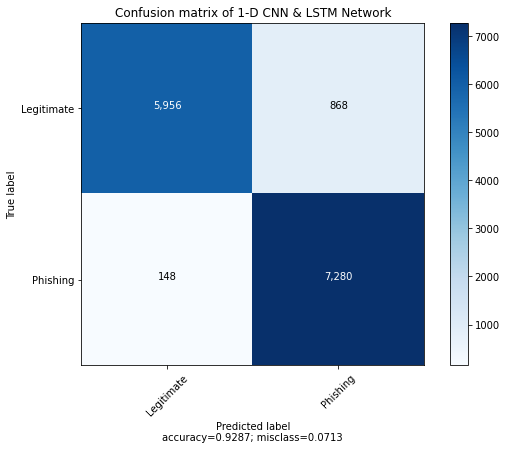

In [57]:
cm3 = confusion_matrix(test_y, pred3)
plot_confusion_matrix(cm           = cm3, 
                      normalize    = False,
                      target_names = ['Legitimate', 'Phishing'],
                      title        = "Confusion matrix of 1-D CNN & LSTM Network")

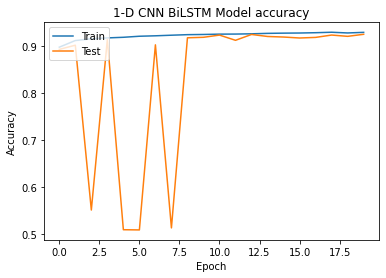

In [58]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('1-D CNN BiLSTM Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

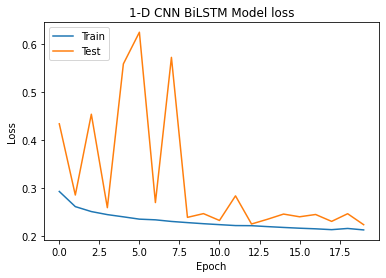

In [59]:
plt.plot(history3.history['loss']) 
plt.plot(history3.history['val_loss']) 
plt.title('1-D CNN BiLSTM Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()